In [ ]:
#import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import shap
from joblib import Parallel, delayed, dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator)  # Renamed variable to avoid conflict
    return smape_value


#global formatting for the plots
plt.rcParams.update({
    'axes.titlesize': 18,    # Title font size
    'axes.labelsize': 14,    # x/y label font size
    'xtick.labelsize': 12,   # x-axis tick label size
    'ytick.labelsize': 12,   # y-axis tick label size
    'legend.fontsize': 12,   # Legend text size
    'legend.title_fontsize': 13  # Legend title size
})

Download data from google drive

In [ ]:
drive.mount('/content/gdrive')

#import time series
datasets = {}
for name in ['sp500', 'eur_usd']:
    datasets[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/{name}_data.csv', index_col=0)
    datasets[name] = datasets[name]
    datasets[name].index.name = 'Date'
    datasets[name].index = pd.to_datetime(datasets[name].index)


Close_price = {}
Log_return = {}
test_residuals = {}
val_residuals = {}
SARIMA_fitted_values = {}
SARIMA_test_predictions = {}

for name , dataset in datasets.items():

    #save Close price and Log Returns into a pd.Series
    Close_price[name] = dataset['Close'].copy().astype(float)
    # Log_return[name] = dataset['Log Return'].copy().astype(float)

    #drop columns not needed
    # dataset.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)
    dataset.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)


    #import SARIMA residuals
    # residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv', index_col=0, sep=",")
    # residuals[name].index = pd.to_datetime(residuals[name].index)


    #val residuals
    val_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_val_residuals.csv', index_col=0, sep=",")
    val_residuals[name].index = pd.to_datetime(val_residuals[name].index)

    #test residuals
    test_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_residuals.csv', index_col=0, sep=",")
    test_residuals[name].index = pd.to_datetime(test_residuals[name].index)

    #import SARIMA fitted values (predictions on the training set)
    SARIMA_fitted_values[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv', index_col=0)
    SARIMA_fitted_values[name].index = pd.to_datetime(SARIMA_fitted_values[name].index)

    #import SARIMA predictions on the test set
    SARIMA_test_predictions[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
    SARIMA_test_predictions[name].index = pd.to_datetime(SARIMA_test_predictions[name].index)

Mounted at /content/gdrive


#XGBoost

##Data preprocessing

In [ ]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
    _x = data.iloc[i:i+seq_length]
    _y = data.iloc[i + seq_length]
    X.append(_x)
    y.append(_y)

    return np.array(X), np.array(y)


train_data = {}
val_data = {}
train_val_data = {}
test_data = {}
scaler = {}
train_data_scaled = {}
val_data_scaled = {}
train_val_data_scaled = {}
test_data_scaled = {}


for name, dataset in datasets.items():

    #univariate sliding window
    train_data[name] = residuals[name].loc[: '2018']
    train_data[name].index = pd.to_datetime(train_data[name].index)

    val_data[name] = residuals[name].loc['2019': '2021']
    val_data[name].index = pd.to_datetime(val_data[name].index)

    train_val_data[name] = residuals[name].loc[: '2021']
    train_val_data[name].index = pd.to_datetime(train_val_data[name].index)

    test_data[name] = residuals[name].loc['2022':]
    test_data[name].index = pd.to_datetime(test_data[name].index)


    #scale the data
    # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
    # scaler = StandardScaler()

    scaler[name] = RobustScaler()
    train_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_data[name].values.reshape(-1, 1)))
    val_data_scaled[name] = pd.DataFrame(scaler[name].transform(val_data[name].values.reshape(-1, 1)))
    train_val_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_val_data[name].values.reshape(-1, 1)))
    test_data_scaled[name] = pd.DataFrame(scaler[name].transform(test_data[name].values.reshape(-1, 1)))


    #sliding windows
    X_train, y_train  = sliding_windows(train_data_scaled, 10)
    X_val, y_val= sliding_windows(val_data_scaled, 10)
    X_test, y_test = sliding_windows(test_data_scaled, 10)
    X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)


    # Flatten the sliding windows
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)


    #convert to Dmatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

##Find the best hyperparameter using Bayesian Optimization

In [ ]:
!pip install arm-mango

In [ ]:
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
import time
from joblib import Parallel, delayed, dump, load
from scipy.stats import uniform


In [ ]:
#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, dtrain, dval):
      self.conf_dict = configuration_params
      self.njobs = njobs
      # self.dtrain = xgb.DMatrix(X_train, label=y_train)
      # self.dval = xgb.DMatrix(X_val, label=y_val)
      self.dtrain = dtrain
      self.dval = dval
      self.space = {
          "learning_rate": uniform(0.01, 0.5),
          "max_depth": range(5, 15),
          "subsample": uniform(0.7, 0.3),
          "objective": ['reg:squarederror'],
          "colsample_bytree": uniform(0.3, 0.7),
          "gamma": uniform(0, 0.01),
          "num_boost_round": range(500, 2000),
          "early_stopping_rounds": range(10, 30),
          "early_stopping_rounds" : [20],
          "lambda": uniform(0, 1),                                # L2 regularization term
          "alpha": uniform(0, 1),                                 # L1 regularization term
      }


    #other hyperparameters that can be used

    # "min_child_weight": randint(1, 10),                     # Min child weight between 1 and 10
    # "scale_pos_weight": uniform(0.5, 2),                    # Scaling for positive class weight
    # "objective": ['reg:squarederror'],                      # Objective function
    # "booster": ['gbtree', 'gblinear', 'dart'],              # Choice of tree booster types
    # "max_delta_step": uniform(0, 10),                       # Maximum step size to help with convergence
    # "lambda": uniform(0, 1),                                # L2 regularization term
    # "alpha": uniform(0, 1),                                 # L1 regularization term




  #This is the loss function that mango optimizes
  def XGBoost_objetive_function(self, **params):
    try:
        # model = xgb.train(params, self.dtrain, num_boost_round=params['num_boost_round'])  # Train model
        model = xgb.train(params, self.dtrain, evals = [(self.dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)
        y_pred = model.predict(self.dval)  # Predict

        #unscale predictions
        # y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(dval.get_label(), y_pred)) # Compute RMSE
        # print(rmse)
        return rmse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch):
    global parameters
    # print(f"Parameters batch: {params_batch}")
    results_batch = Parallel(self.njobs, backend="threading")(delayed(self.XGBoost_objetive_function)(**params) for params in params_batch)
    # print(f"Results batch: {results_batch}")
    rmse = [result for result in results_batch]
    return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


# Parallel hyperparameters tuning
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, dtrain = dtrain, dval = dval) #initialize a new instance of the class
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')


# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)


  0%|          | 0/40 [00:00<?, ?it/s]

The optimisation in parallel takes 3.642680021127065 minutes.
best parameters: {'alpha': 0.07974876214479332, 'colsample_bytree': 0.4505624091260668, 'early_stopping_rounds': 20, 'gamma': 0.005882153523315466, 'lambda': 0.6591718388148139, 'learning_rate': 0.4770299725862893, 'max_depth': 10, 'num_boost_round': 1582, 'objective': 'reg:squarederror', 'subsample': 0.750301020293294}
best accuracy: 0.4179854345111082


## Inference

RMSE: 237.70801745523855
Mean Squared Error: 56505.1015625
Mean Absolute Error: 164.47299194335938
R2 Score: 0.49124711751937866


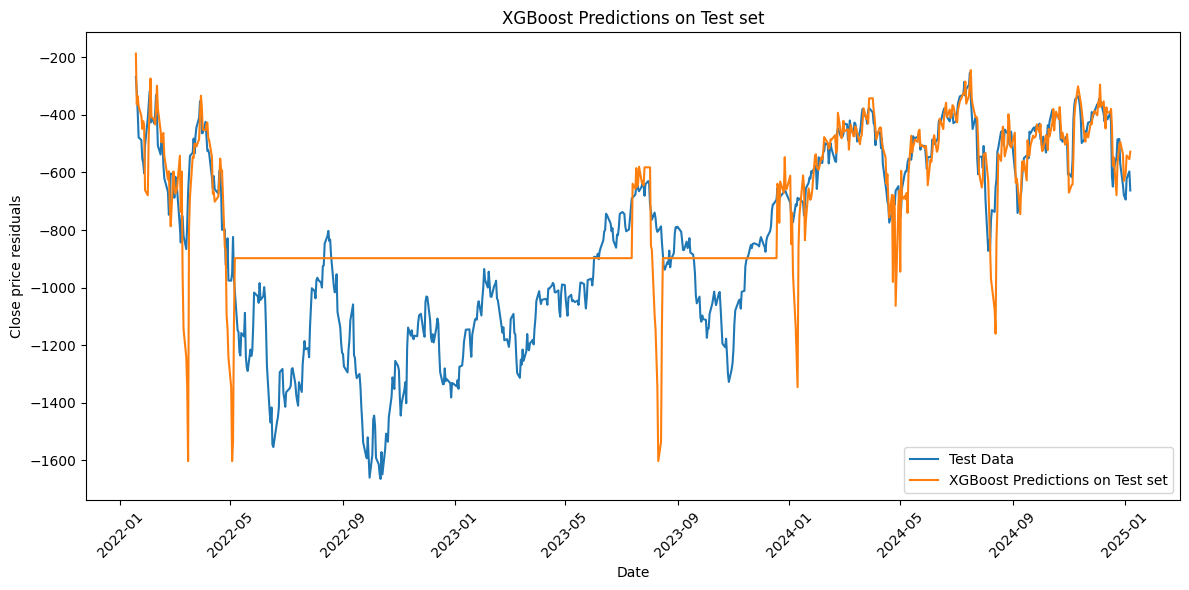

RMSE: 11.12606463535151
Mean Squared Error: 123.78931427001953
Mean Absolute Error: 7.912360191345215
R2 Score: 0.9951931238174438


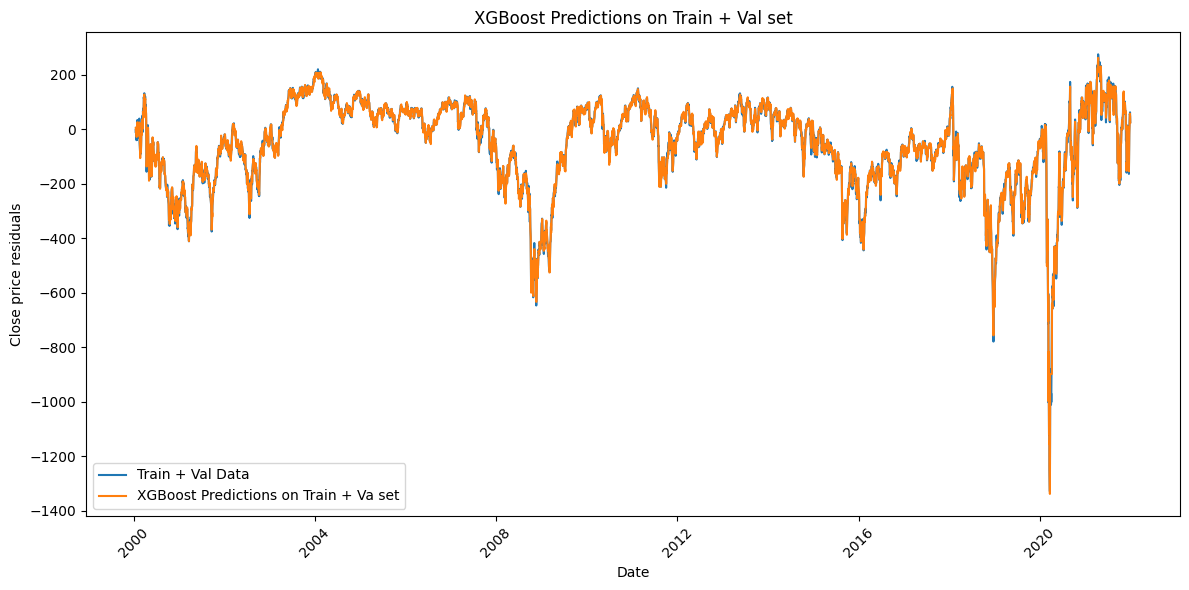

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib']

In [ ]:
# train model using the best hyperparameters
# best_params ={'colsample_bytree': 0.808411208122622, 'early_stopping_rounds': 17, 'gamma': 0.0005022072348654649, 'learning_rate': 0.3196968954529591, 'max_depth': 14, 'num_boost_round': 1949, 'objective': 'reg:squarederror', 'subsample': 0.7712161804793591}
# best_params = {'colsample_bytree': 0.45298491613255965, 'early_stopping_rounds': 16, 'gamma': 0.0033010903221791198, 'learning_rate': 0.4062593003755195, 'max_depth': 10, 'num_boost_round': 1445, 'objective': 'reg:squarederror', 'subsample': 0.9637993843394563}
# best_params: {'colsample_bytree': 0.8363746113200037, 'early_stopping_rounds': 19, 'gamma': 0.003066575136600952, 'learning_rate': 0.30104358076393695, 'max_depth': 9, 'num_boost_round': 535, 'objective': 'reg:squarederror', 'subsample': 0.8306946262106537}

best_params = {'alpha': 0.07974876214479332, 'colsample_bytree': 0.4505624091260668, 'early_stopping_rounds': 20, 'gamma': 0.005882153523315466, 'lambda': 0.6591718388148139, 'learning_rate': 0.4770299725862893, 'max_depth': 10, 'num_boost_round': 1582, 'objective': 'reg:squarederror', 'subsample': 0.750301020293294}
# best_params = {'alpha': 0.3223045480428064, 'colsample_bytree': 0.7986340282443237, 'early_stopping_rounds': 20, 'gamma': 0.006850732712355683, 'lambda': 0.6185707666412035, 'learning_rate': 0.48612569577423054, 'max_depth': 7, 'num_boost_round': 784, 'objective': 'reg:squarederror', 'subsample': 0.9753460207084007}
model = xgb.train(best_params, dtrain_val, evals = [(dval, 'validation')], num_boost_round = best_params['num_boost_round'], early_stopping_rounds= best_params['early_stopping_rounds'], verbose_eval=False)  # Initialize xgboost model


#predictions
y_test_pred = model.predict(dtest)
y_train_val_pred = model.predict(dtrain_val)


#unscale predictions
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_val_pred = scaler.inverse_transform(y_train_val_pred.reshape(-1, 1))


#compute metrics
mse = mean_squared_error(test_data[10:], y_test_pred)
rmse = np.sqrt(mean_squared_error(test_data[10:], y_test_pred))
mae = mean_absolute_error(test_data[10:], y_test_pred)
r2 = r2_score(test_data[10:], y_test_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
# sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
sns.lineplot(x= test_data[10:].index, y = test_data[10:].squeeze(), label="Test Data")
sns.lineplot(x=test_data[10:].index, y=y_test_pred.squeeze(), label="XGBoost Predictions on Test set")
plt.title('XGBoost Predictions on Test set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


mse = mean_squared_error(train_val_data[10:], y_train_val_pred)
rmse = np.sqrt(mean_squared_error(train_val_data[10:], y_train_val_pred))
mae = mean_absolute_error(train_val_data[10:], y_train_val_pred)
r2 = r2_score(train_val_data[10:], y_train_val_pred)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_val_data[10:].index, y = train_val_data[10:].squeeze(), label="Train + Val Data")
sns.lineplot(x=train_val_data[10:].index, y=y_train_val_pred.squeeze(), label="XGBoost Predictions on Train + Va set")
plt.title('XGBoost Predictions on Train + Val set')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#save model on google drive
drive.mount("/content/gdrive")
file_path = '/content/gdrive/MyDrive/università/Tesi/models/XGBoost_model_univariate_sliding_windows.joblib'
dump(model, file_path)

##Combine ARIMA + XGBoost

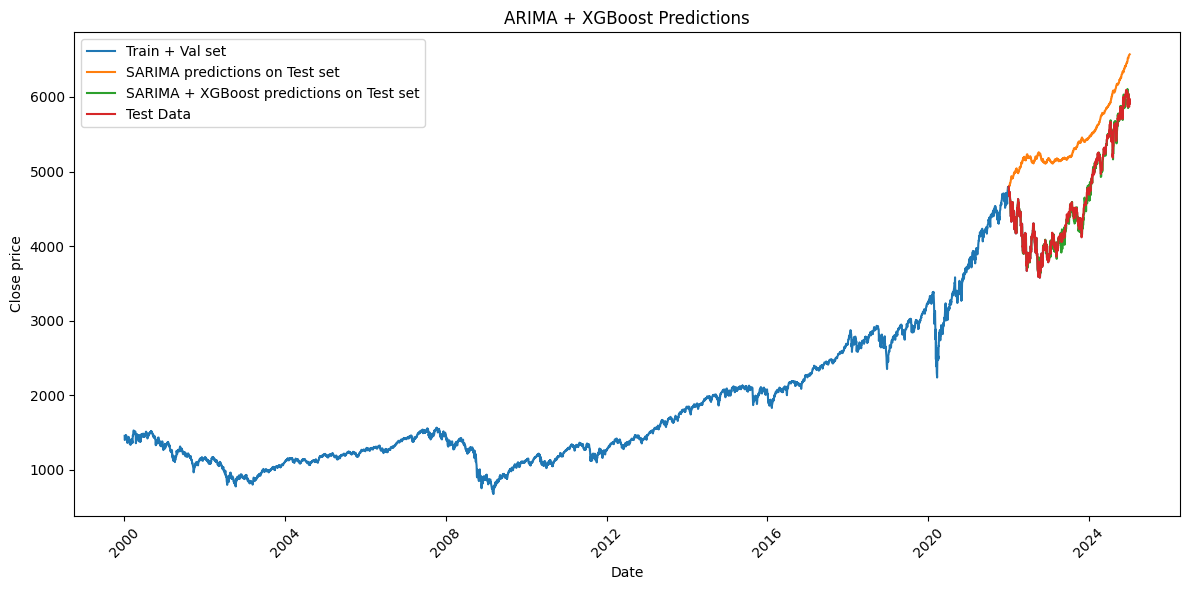

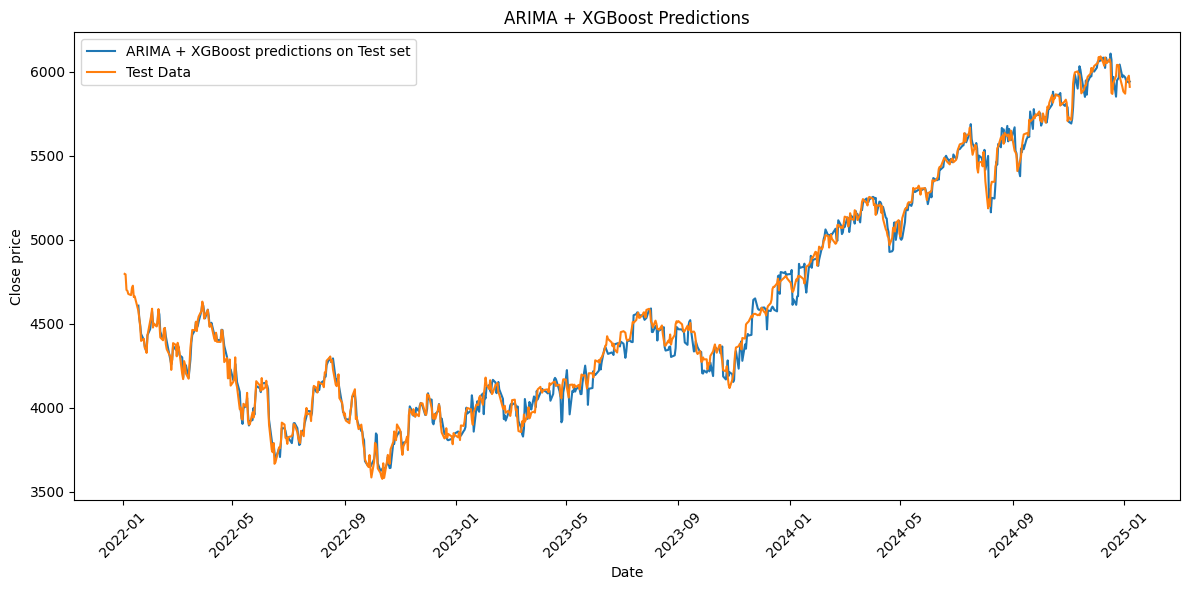

RMSE: 54.65960036596571
Mean Squared Error: 2987.671912167079
Mean Absolute Error: 40.6702508450928
R2 Score: 0.9933633326723577


In [ ]:
SARIMA_XGBoost_predictions = SARIMA_test_predictions[10:] + y_test_pred.squeeze()

#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index], label="Train + Val set")
sns.lineplot(x=test_data.index, y=SARIMA_test_predictions.values, label="SARIMA predictions on Test set")
# sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
sns.lineplot(x=test_data[10:].index, y=SARIMA_XGBoost_predictions, label="SARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data[10:].index, y=SARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions on Test set")
sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
plt.title('ARIMA + XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
mse = mean_squared_error(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
r2 = r2_score(Close_price.loc[test_data[10:].index ], SARIMA_XGBoost_predictions)
print(f'RMSE: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')


#save predictions
SARIMA_XGBoost_predictions = pd.Series(SARIMA_XGBoost_predictions, index=test_data.index)
path = "/content/gdrive/MyDrive/università/Machine_learning/Project_code/XGBoost/SARIMA_XGBoost_predictions.csv"
SARIMA_XGBoost_predictions.to_csv(path, index=True)

#Naive model

MSE:  570561.9042888356
RMSE:  755.3554820671096
MAE:  593.5665020938114
R2:  -1.4396191182451599


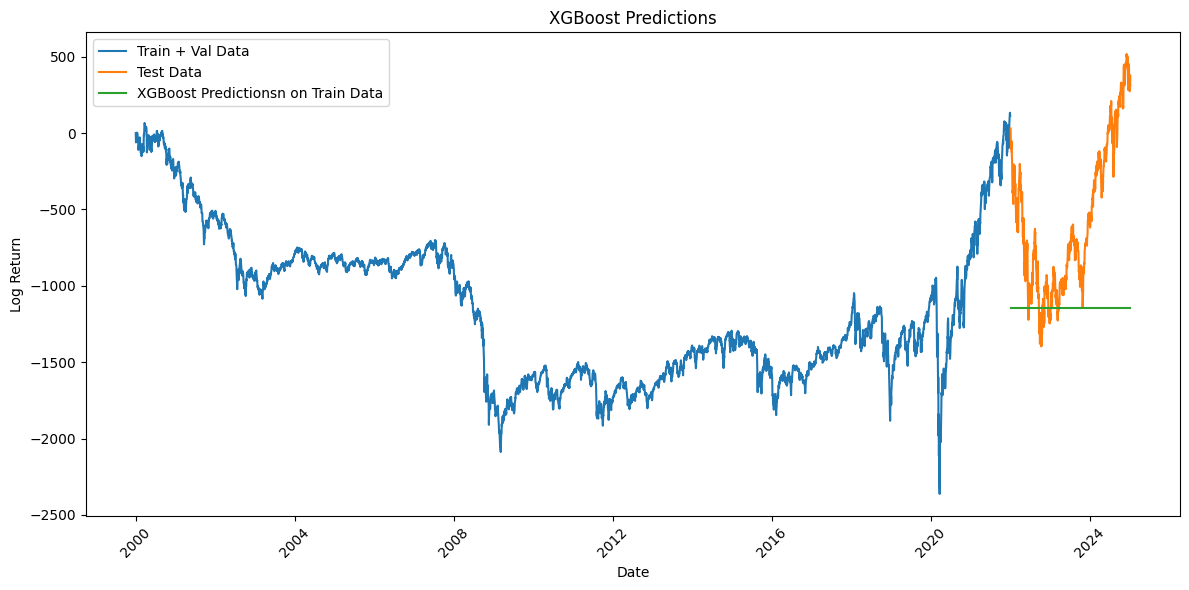

In [ ]:
#naive model that predict the means
class naive_estimator:
    def __init__(self):
        self.mean_value = None  # Initialize mean

    def fit(self, train_data):
      self.mean_value = np.mean(train_data.iloc[:,0])

    def predict(self, test_data):
      return np.full(len(test_data), self.mean_value)  # Creates array of mean values


train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2022']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)


#train + fit naive model
mean_esitmator = naive_estimator()
mean_esitmator.fit(train_val_data)
test_predictions = mean_esitmator.predict(test_data)


mse = mean_squared_error(test_data, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, test_predictions)
r2 = r2_score(test_data, test_predictions)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('R2: ', r2)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_val_data.index, y=train_val_data.squeeze(), label="Train + Val Data")
sns.lineplot(x=test_data.index, y=test_data.squeeze(), label="Test Data")
sns.lineplot(x=test_data.index, y=test_predictions, label="XGBoost Predictionsn on Train Data")
plt.title('XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#Linear Booster

In [ ]:
!pip install --upgrade linear-tree

In [ ]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearBoostRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)


train_data = {}
val_data = {}
train_val_data = {}
test_data = {}
scaler = {}
train_data_scaled = {}
val_data_scaled = {}
train_val_data_scaled = {}
test_data_scaled = {}

X_train = {}
X_val = {}
X_train_val = {}
X_test = {}
y_train = {}
y_val = {}
y_train_val = {}
y_test = {}


for name, dataset in datasets.items():

    #univariate sliding window
    train_data[name] = val_residuals[name]
    train_data[name].index = pd.to_datetime(val_residuals[name].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)


    #scale the data
    if name == "sp500":
        scaler[name] = RobustScaler()
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # scaler = StandardScaler()

    elif name == "eur_usd":
        scaler[name] = RobustScaler()
        # scaler[name] = MinMaxScaler(feature_range=(-1, 1))
        # scaler[name] = StandardScaler()


    train_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_data[name].values.reshape(-1, 1)))
    test_data_scaled[name] = pd.DataFrame(scaler[name].transform(test_data[name].values.reshape(-1, 1)))


    #sliding windows
    X_train[name], y_train[name]  = sliding_windows(train_data_scaled[name], 10)
    X_test[name] , y_test[name] = sliding_windows(test_data_scaled[name], 10)


    # Flatten the sliding windows
    X_train[name] = X_train[name].reshape(X_train[name].shape[0], -1)
    X_test[name] = X_test[name].reshape(X_test[name].shape[0], -1)

##Find the best hyperparameter using Bayesian Optimization

In [ ]:
!pip install arm-mango

In [ ]:
from mango import scheduler #to perform Bayesian optimization
from mango.tuner import Tuner
import time
from joblib import Parallel, delayed, dump, load
from scipy.stats import uniform


In [ ]:
name = "sp500"

#parallel bayesian optimization
class OptimizationMangoParallel:
  def __init__(self, njobs: int, configuration_params: dict, X_train, y_train, X_val, y_val):
      self.conf_dict = configuration_params
      self.njobs = njobs
      self.X_train = X_train
      self.y_train = y_train
      self.X_val = X_val
      self.y_val = y_val
      self.space = {
        "n_estimators": range(50, 500),
        "max_depth": range(3, 15),
        "min_samples_split": range(2, 20),
        "min_samples_leaf": range(1, 20),
        "alpha": uniform(0.01, 10)
}





  #This is the loss function that mango optimizes
  def XGBoost_objetive_function(self, **params):
    try:
        n_estimators = params["n_estimators"]
        max_depth = params["max_depth"]
        min_samples_split = params["min_samples_split"]
        min_samples_leaf = params["min_samples_leaf"]
        alpha = params["alpha"]

        print(f"training: Ridge(alpha={alpha}), n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
        model = LinearBoostRegressor(base_estimator=Ridge(alpha=alpha), n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        model.fit(self.X_train, self.y_train)

        #predict
        y_pred = model.predict(self.X_val)

        # unscale predictions
        y_pred = scaler[name].inverse_transform(y_pred.reshape(-1, 1))

        rmse = np.sqrt(mean_squared_error(val_data[10:], y_pred)) # Compute RMSE
        # print(rmse)
        return rmse
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return 1e5  # Penalize error cases


  def _objective2(self, params_batch):
    global parameters
    # print(f"Parameters batch: {params_batch}")
    results_batch = Parallel(self.njobs, backend="threading")(delayed(self.XGBoost_objetive_function)(**params) for params in params_batch)
    # print(f"Results batch: {results_batch}")
    rmse = [result for result in results_batch]
    return rmse


  def mango_optimization(self):
      tuner = Tuner(self.space, self._objective2, self.conf_dict)
      optimisation_results = tuner.minimize()
      return optimisation_results['best_params'], optimisation_results['best_objective']


# Parallel hyperparameters tuning
config_params = {'num_iteration': 40, 'initial_random': 10}
start_time = time.time()
optim = OptimizationMangoParallel(njobs=4, configuration_params=config_params, X_train=X_train[name], y_train=y_train[name], X_val=X_val[name] , y_val = y_val[name]) #initialize a new instance of the class
best_parameters, best_objective = optim.mango_optimization()
print(f'The optimisation in parallel takes {(time.time() - start_time) / 60.} minutes.')


# Inspect the results
print('best parameters:', best_parameters)
print('best accuracy:', best_objective)


training: Ridge(alpha=0.6927514796684131), n_estimators=159, max_depth=9, min_samples_split=3, min_samples_leaf=4training: Ridge(alpha=2.6914475808597116), n_estimators=140, max_depth=11, min_samples_split=3, min_samples_leaf=14
training: Ridge(alpha=6.231341643653616), n_estimators=115, max_depth=10, min_samples_split=11, min_samples_leaf=10

training: Ridge(alpha=9.766951987597949), n_estimators=319, max_depth=13, min_samples_split=11, min_samples_leaf=14
Error with params {'alpha': 6.231341643653616, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 11, 'n_estimators': 115}: unhashable type: 'slice'
training: Ridge(alpha=8.35316126445996), n_estimators=121, max_depth=6, min_samples_split=8, min_samples_leaf=14
Error with params {'alpha': 0.6927514796684131, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 159}: unhashable type: 'slice'
training: Ridge(alpha=5.322282089015609), n_estimators=495, max_depth=6, min_samples_split=14, min_samples_

##Residual prediction

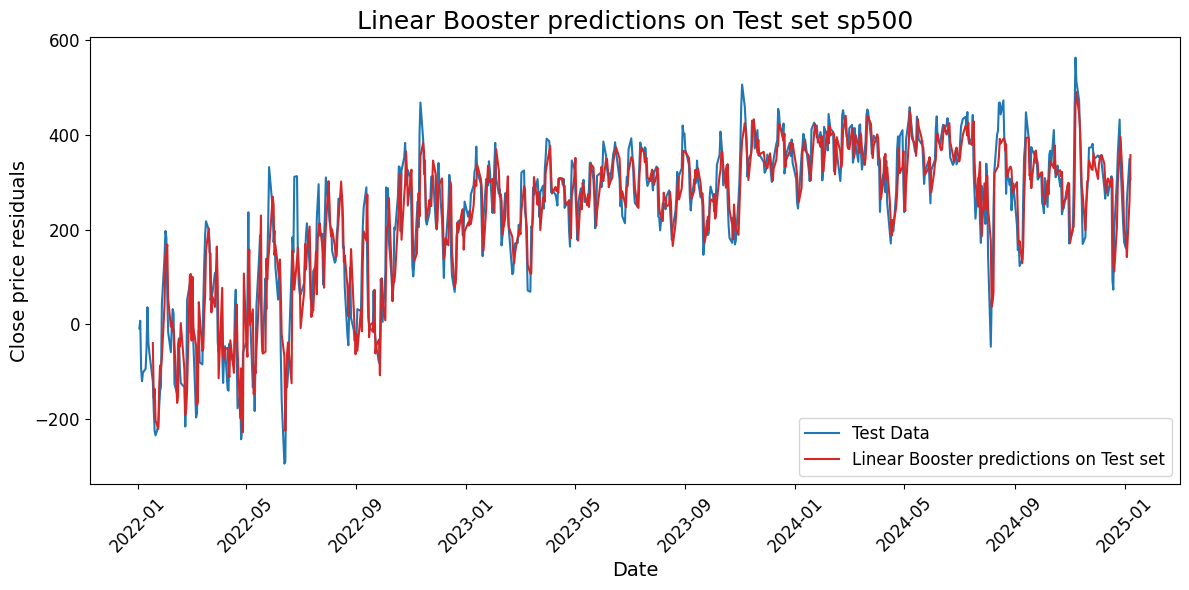

RMSE: 60.78967245629598
Mean Squared Error: 3695.38427734375
Mean Absolute Error: 45.823951721191406
R2 Score: 0.8430673480033875
MAPE: 0.5062775611877441
SMAPE: 0.3155755040100817


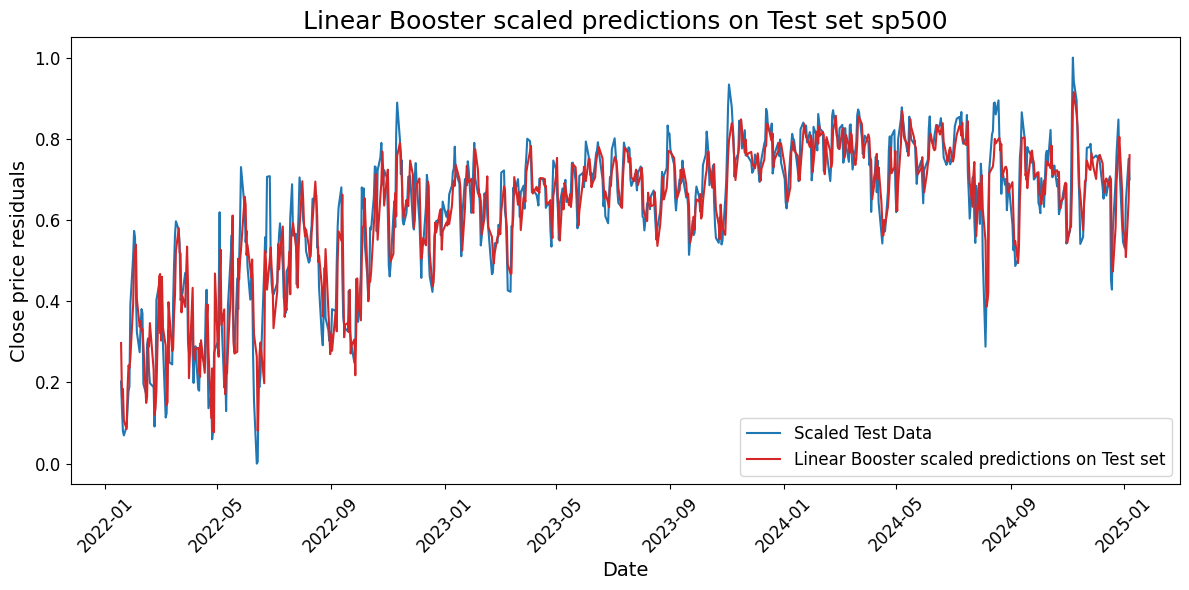

RMSE: 0.07078470225526737
Mean Squared Error: 0.005010474073366853
Mean Absolute Error: 0.053358323865776075
R2 Score: 0.8430673710689368


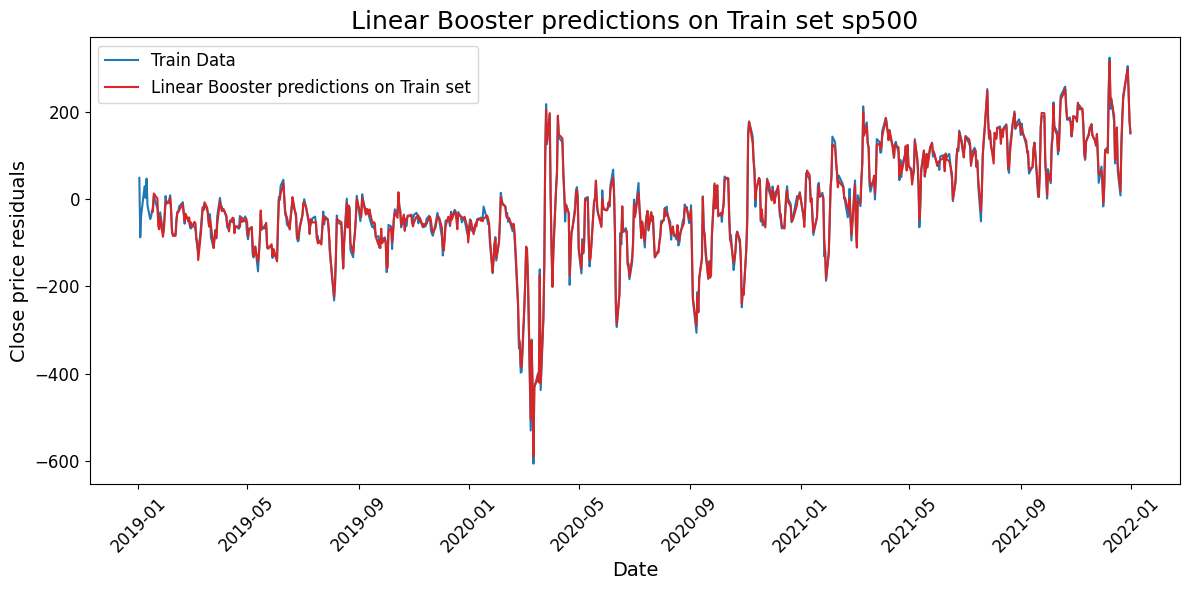

RMSE: 9.35757658274583
Mean Squared Error: 87.56423950195312
Mean Absolute Error: 7.393556594848633
R2 Score: 0.9935723543167114
MAPE: 0.4783822000026703
SMAPE: 0.21807010534106044


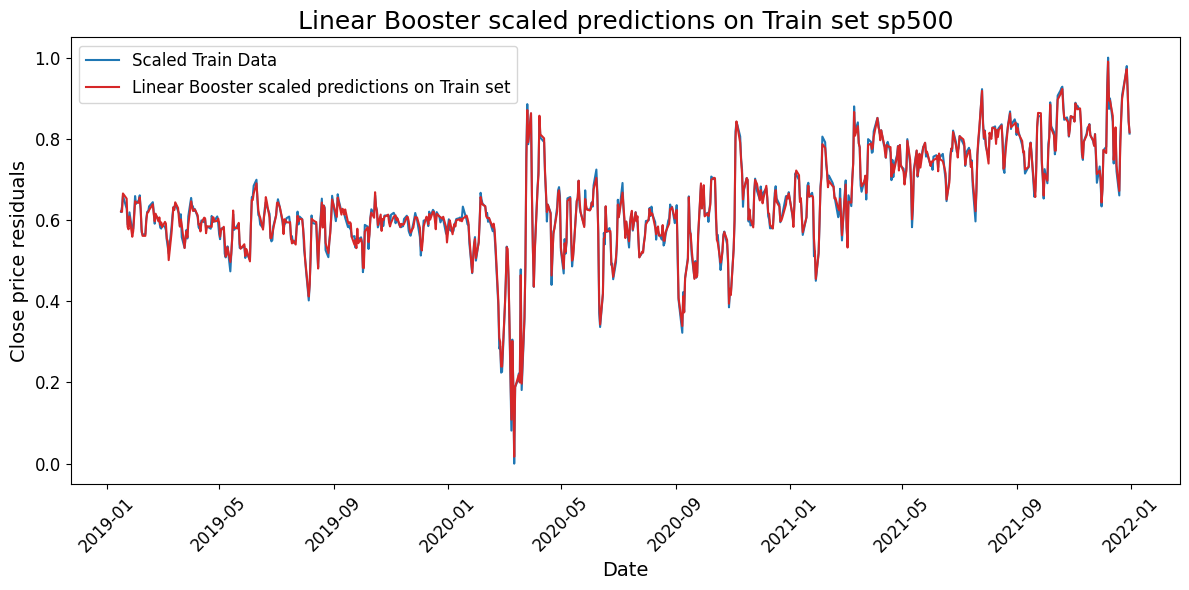

RMSE: 0.010056801062190094
Mean Squared Error: 0.00010113924760446781
Mean Absolute Error: 0.007946024264938813
R2 Score: 0.9935723757056278
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


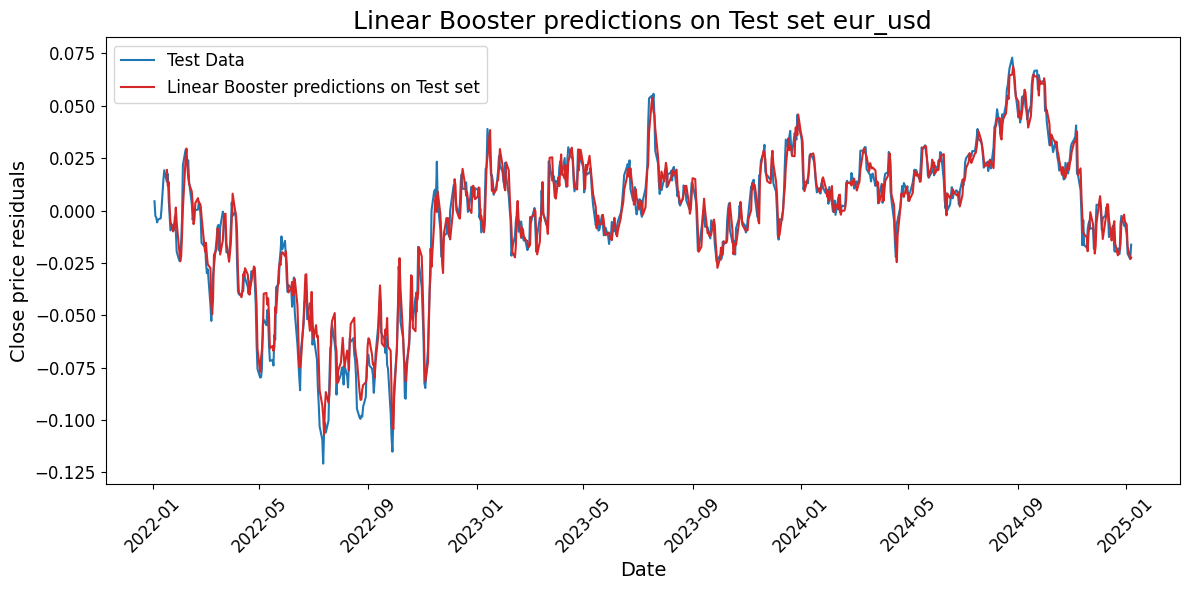

RMSE: 0.007370292023785253
Mean Squared Error: 5.432120451587252e-05
Mean Absolute Error: 0.005658474285155535
R2 Score: 0.9570401310920715
MAPE: 2.5467658042907715
SMAPE: 0.4604497584264449


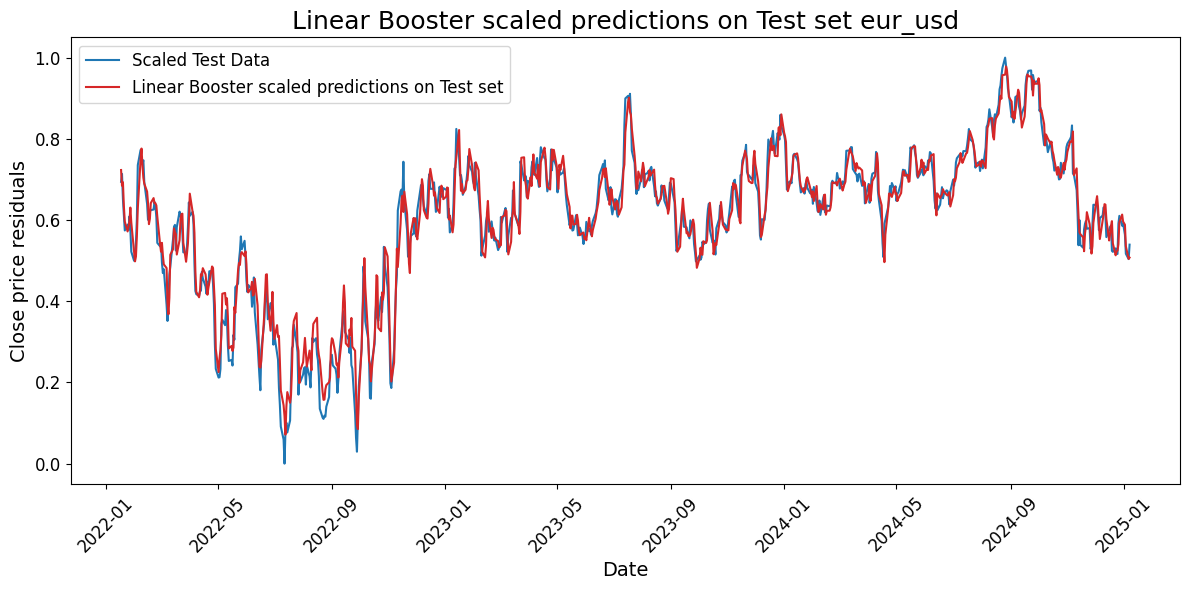

RMSE: 0.03803661939674053
Mean Squared Error: 0.0014467844151324978
Mean Absolute Error: 0.029202266218213313
R2 Score: 0.95704010534101


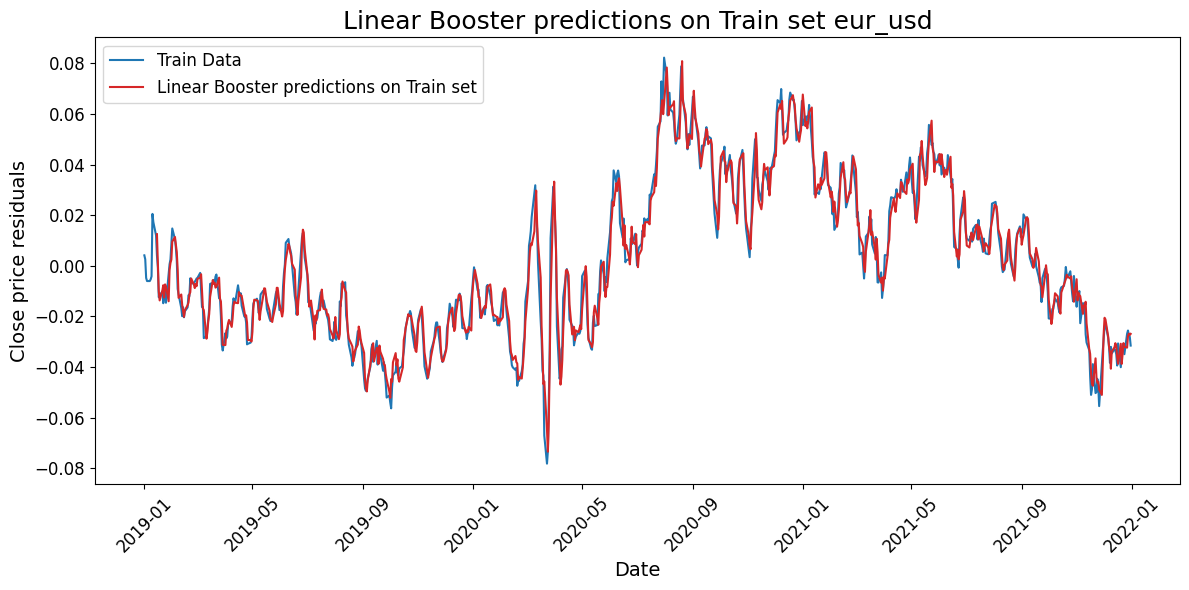

RMSE: 0.005208261582195751
Mean Squared Error: 2.7125988708576187e-05
Mean Absolute Error: 0.003975525964051485
R2 Score: 0.9711561799049377
MAPE: 0.5879809260368347
SMAPE: 0.29240753016387433


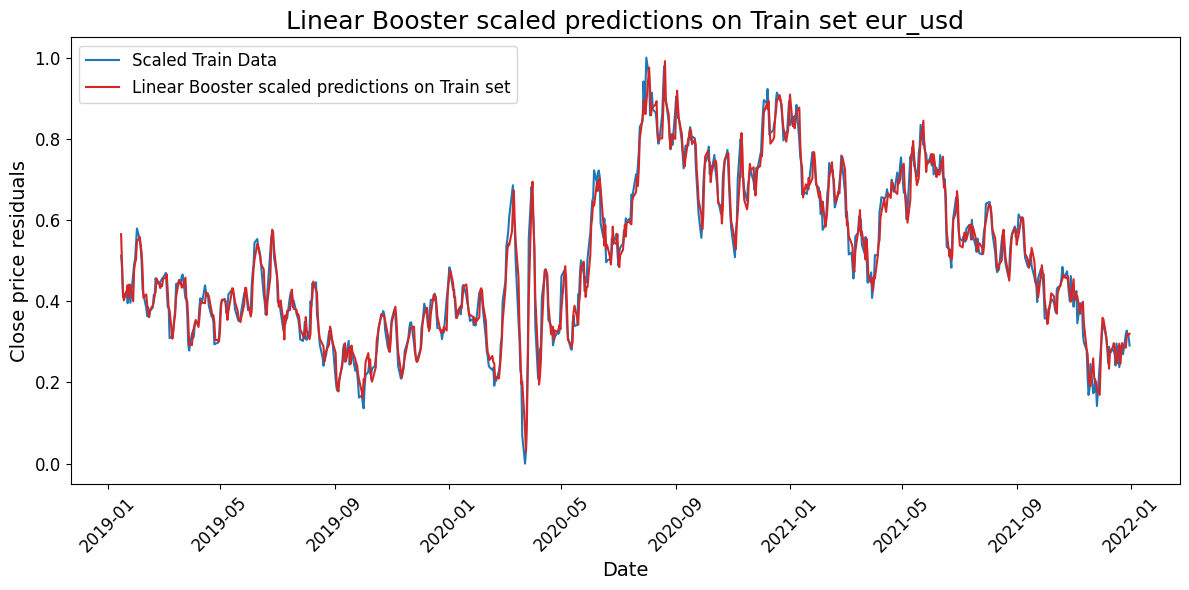

RMSE: 0.03248521451728629
Mean Squared Error: 0.0010552891622341077
Mean Absolute Error: 0.024796337253940873
R2 Score: 0.971156157853684
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model = {}
y_test_pred = {}
y_train_pred = {}


for name, dataset in datasets.items():

    # best_params = {"n_estimators": 300,  "max_depth": 5,  "min_samples_split" : 5, "min_samples_leaf" : 0.1}
    if name == "sp500":
        # best_params = {"n_estimators": 300,  "max_depth": 10,  "min_samples_split" : 10, "min_samples_leaf" : 0.01}
        best_params = {"n_estimators": 180,  "max_depth": 10,  "min_samples_split" : 10, "min_samples_leaf" : 0.01}
        ridge = Ridge(alpha=2)
    elif name == "eur_usd":
        # best_params = {"n_estimators": 5,  "max_depth": 8,  "min_samples_split" : 5, "min_samples_leaf" : 0.01}
        best_params = {"n_estimators": 5,  "max_depth": 11,  "min_samples_split" : 5, "min_samples_leaf" : 0.01}
        ridge = Ridge(alpha=2)

    # best_params = {'alpha': 3.7802575891260792, 'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 10, 'n_estimators': 164}
    # alpha = best_params["alpha"]
    # best_params.pop('alpha', None)


    #fit model
    model[name] = LinearBoostRegressor(base_estimator=ridge, **best_params)
    model[name].fit(X_train[name], y_train[name])


    #predictions
    y_test_pred[name] = model[name].predict(X_test[name])
    y_train_pred[name] = model[name].predict(X_train[name])


    #unscale predictions
    y_test_pred[name] = scaler[name].inverse_transform(y_test_pred[name].reshape(-1, 1))
    y_train_pred[name] = scaler[name].inverse_transform(y_train_pred[name].reshape(-1, 1))


    #visualize
    colors = ["#1f77b4", "#d62728"]
    plt.figure(figsize=(12, 6))
    # sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
    sns.lineplot(x= test_data[name].index, y = test_data[name].squeeze(), label="Test Data", color = colors[0])
    sns.lineplot(x=test_data[name][10:].index, y=y_test_pred[name].squeeze(), label="Linear Booster predictions on Test set", color = colors[1])
    plt.title(f'Linear Booster predictions on Test set {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price residuals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()

    #compute metrics
    mse = mean_squared_error(test_data[name][10:], y_test_pred[name])
    rmse = np.sqrt(mean_squared_error(test_data[name][10:], y_test_pred[name]))
    mae = mean_absolute_error(test_data[name][10:], y_test_pred[name])
    r2 = r2_score(test_data[name][10:], y_test_pred[name])
    mape = mean_absolute_percentage_error(test_data[name][10:], y_test_pred[name])
    smape_result = smape(test_data[name][10:], y_test_pred[name])

    print(f'RMSE: {rmse}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    print(f'MAPE: {mape}')
    print(f'SMAPE: {smape_result}')


    #scale dataset to compute metrics
    metrics_scaer = MinMaxScaler() #range 0-1
    scaled_test = pd.DataFrame(metrics_scaer.fit_transform(test_data[name].values.reshape(-1, 1)), index = test_data[name].index)
    scaled_pred = pd.DataFrame(metrics_scaer.transform(y_test_pred[name].reshape(-1, 1)), index = test_data[name][10:].index)


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=scaled_test[10:].index, y=scaled_test[10:].squeeze(), label="Scaled Test Data", color = colors[0])
    sns.lineplot(x= scaled_pred.index, y = scaled_pred.squeeze(), label="Linear Booster scaled predictions on Test set", color = colors[1])
    plt.title(f'Linear Booster scaled predictions on Test set {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price residuals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #scaled metrics
    nmse = mean_squared_error(scaled_test[10:], scaled_pred)
    nrmse = np.sqrt(mean_squared_error(scaled_test[10:], scaled_pred))
    nmae = mean_absolute_error(scaled_test[10:], scaled_pred)
    nr2 = r2_score(scaled_test[10:], scaled_pred)
    nmape = mean_absolute_percentage_error(scaled_test[10:], scaled_pred)
    nsmape_result = smape(scaled_test[10:], scaled_pred)

    print(f'RMSE: {nrmse}')
    print(f'Mean Squared Error: {nmse}')
    print(f'Mean Absolute Error: {nmae}')
    print(f'R2 Score: {nr2}')
    # print(f'MAPE: {nmape}')
    # print(f'SMAPE: {nsmape_result}')


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x= train_data[name].index, y = train_data[name].squeeze(), label="Train Data", color = colors[0])
    sns.lineplot(x=train_data[name][10:].index, y=y_train_pred[name].squeeze(), label="Linear Booster predictions on Train set", color = colors[1])
    plt.title(f'Linear Booster predictions on Train set {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price residuals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #unscaled metrics
    mse = mean_squared_error(train_data[name][10:], y_train_pred[name])
    rmse = np.sqrt(mean_squared_error(train_data[name][10:], y_train_pred[name]))
    mae = mean_absolute_error(train_data[name][10:], y_train_pred[name])
    r2 = r2_score(train_data[name][10:], y_train_pred[name])
    mape = mean_absolute_percentage_error(train_data[name][10:], y_train_pred[name])
    smape_result = smape(train_data[name][10:], y_train_pred[name])


    print(f'RMSE: {rmse}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    print(f'MAPE: {mape}')
    print(f'SMAPE: {smape_result}')


    #scale dataset to compute metrics
    metrics_scaer = MinMaxScaler() #range 0-1
    scaled_train = pd.DataFrame(metrics_scaer.fit_transform(train_data[name].values.reshape(-1, 1)), index = train_data[name].index)
    scaled_pred = pd.DataFrame(metrics_scaer.transform(y_train_pred[name].reshape(-1, 1)), index = train_data[name][10:].index)

    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=scaled_train[10:].index, y=scaled_train[10:].squeeze(), label="Scaled Train Data", color = colors[0])
    sns.lineplot(x=scaled_pred.index, y = scaled_pred.squeeze(), label="Linear Booster scaled predictions on Train set", color = colors[1])
    plt.title(f'Linear Booster scaled predictions on Train set {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price residuals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #scaled metrics
    nmse = mean_squared_error(scaled_train[10:], scaled_pred)
    nrmse = np.sqrt(mean_squared_error(scaled_train[10:], scaled_pred))
    nmae = mean_absolute_error(scaled_train[10:], scaled_pred)
    nr2 = r2_score(scaled_train[10:], scaled_pred)
    nmape = mean_absolute_percentage_error(scaled_train[10:], scaled_pred)
    nsmape_result = smape(scaled_train[10:], scaled_pred)

    print(f'RMSE: {nrmse}')
    print(f'Mean Squared Error: {nmse}')
    print(f'Mean Absolute Error: {nmae}')
    print(f'R2 Score: {nr2}')
    # print(f'MAPE: {nmape}')
    # print(f'SMAPE: {nsmape_result}')


    #save model on google drive
    drive.mount("/content/gdrive")
    file_path = f'/content/gdrive/MyDrive/università/Tesi/models/{name}/Linear_booster.joblib'
    dump(model[name], file_path)

##SARIMA + Linear booster

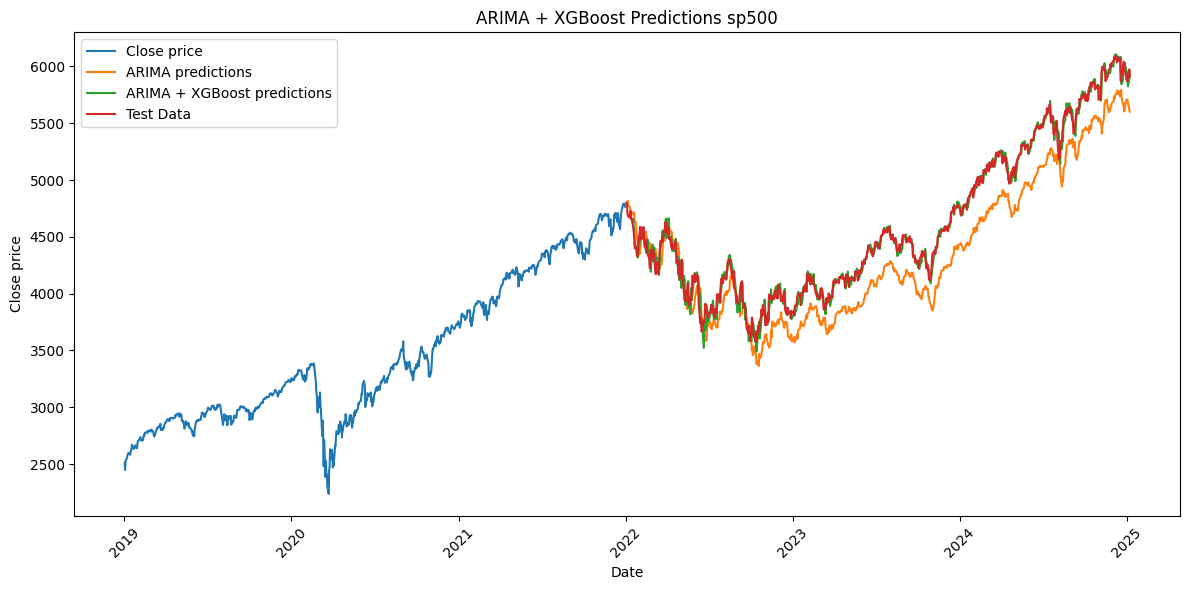

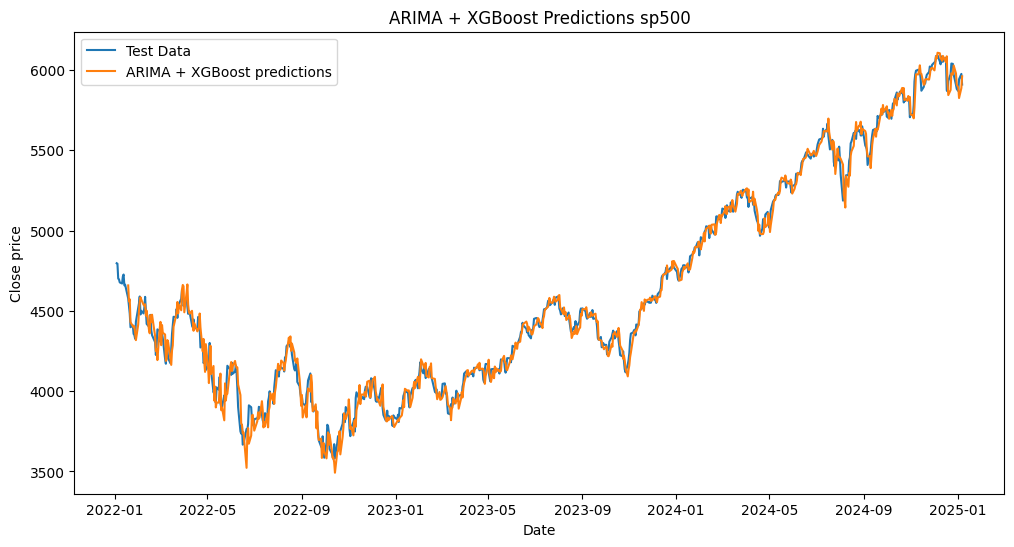

RMSE: 60.78967047674786
Mean Squared Error: 3695.3840366715904
Mean Absolute Error: 45.823953828287884
R2 Score: 0.9917912557937192
MAPE: 0.010321434022795234
SMAPE: 0.010332100136624861


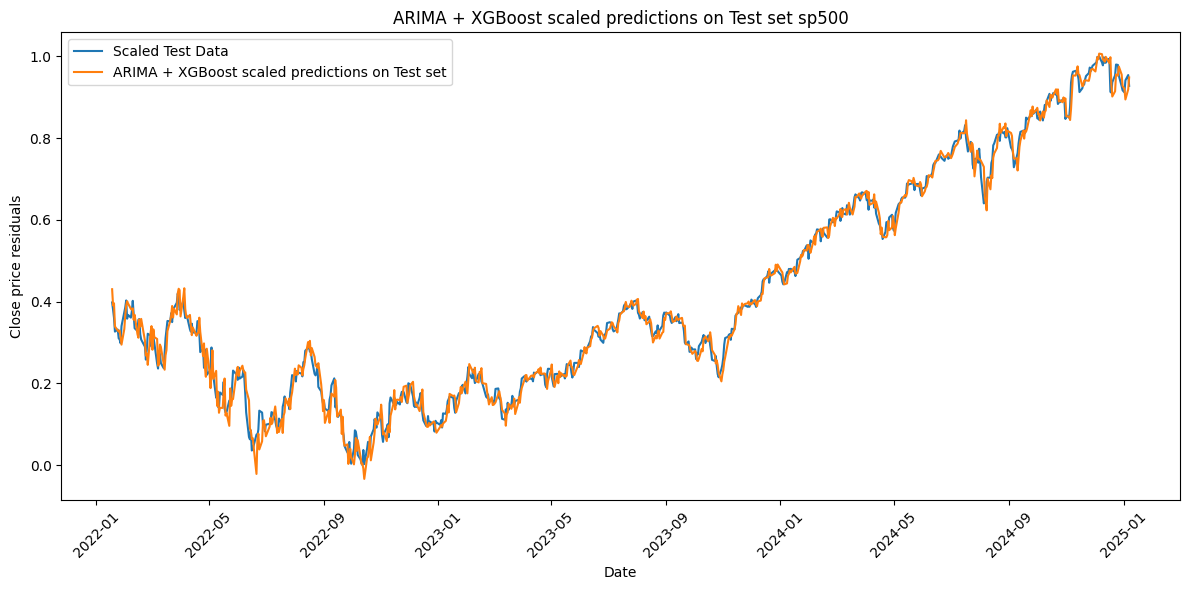

RMSE: 0.02418776985602512
Mean Squared Error: 0.0005850482106080375
Mean Absolute Error: 0.018233019531101183
R2 Score: 0.9917912557937192
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


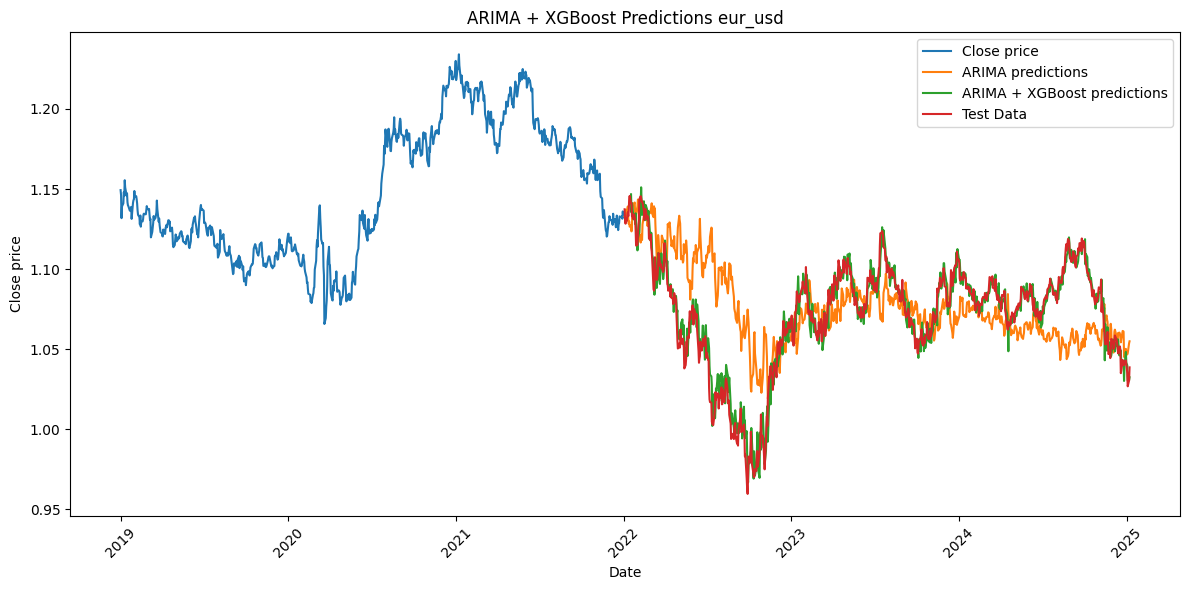

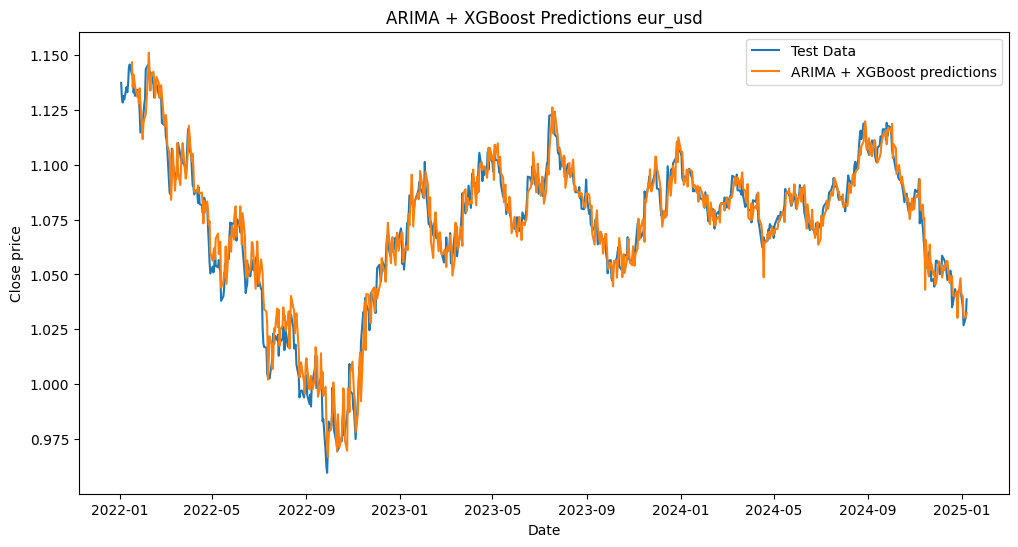

RMSE: 0.007380678972132053
Mean Squared Error: 5.4474422089672256e-05
Mean Absolute Error: 0.005657171283095072
R2 Score: 0.9533517269633678
MAPE: 0.005328616647542072
SMAPE: 0.005322000752754577


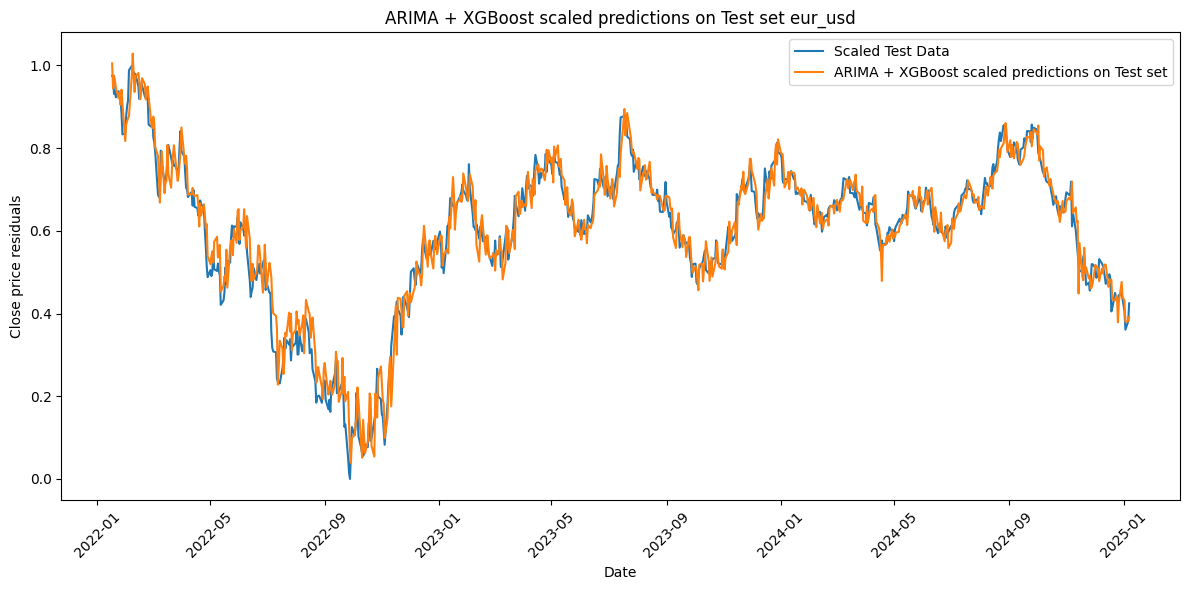

RMSE: 0.03966137196299087
Mean Squared Error: 0.0015730244259867182
Mean Absolute Error: 0.030399801341362238
R2 Score: 0.9533517269633678
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
for name, dataset in datasets.items():

    SARIMA_XGBoost_predictions = SARIMA_test_predictions[name][10:] + y_test_pred[name].reshape(-1)


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_data[name].index, y=Close_price[name].loc[train_data[name].index], label="Close price")
    sns.lineplot(x=test_data[name].index, y=SARIMA_test_predictions[name].values.ravel(), label="ARIMA predictions")
    # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
    sns.lineplot(x=test_data[name][10:].index, y=SARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")
    sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
    plt.title(f'ARIMA + XGBoost Predictions {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #close up
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_data[name].index, y=Close_price[name].loc[test_data[name].index ], label="Test Data")
    sns.lineplot(x=test_data[name][10:].index, y=SARIMA_XGBoost_predictions, label="ARIMA + XGBoost predictions")
    plt.title(f'ARIMA + XGBoost Predictions {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.show()


    #compute metrics
    mse = mean_squared_error(Close_price[name].loc[test_data[name][10:].index], SARIMA_XGBoost_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Close_price[name].loc[test_data[name][10:].index], SARIMA_XGBoost_predictions)
    r2 = r2_score(Close_price[name].loc[test_data[name][10:].index], SARIMA_XGBoost_predictions)
    mape = mean_absolute_percentage_error(Close_price[name].loc[test_data[name][10:].index], SARIMA_XGBoost_predictions)
    smape_result = smape(Close_price[name].loc[test_data[name][10:].index], SARIMA_XGBoost_predictions)


    print(f'RMSE: {rmse}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R2 Score: {r2}')
    print(f'MAPE: {mape}')
    print(f'SMAPE: {smape_result}')


    #scale dataset to compute metrics
    metrics_scaer = MinMaxScaler() #range 0-1
    scaled_test = pd.DataFrame(metrics_scaer.fit_transform(Close_price[name].loc[test_data[name].index].values.reshape(-1, 1)), index = test_data[name].index)
    scaled_pred = pd.DataFrame(metrics_scaer.transform(SARIMA_XGBoost_predictions.values.reshape(-1, 1)), index = test_data[name][10:].index)


    #visualize
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=scaled_test[10:].index, y=scaled_test[10:].squeeze(), label="Scaled Test Data")
    sns.lineplot(x=scaled_pred.index, y = scaled_pred.squeeze(), label="ARIMA + XGBoost scaled predictions on Test set")
    plt.title(f'ARIMA + XGBoost scaled predictions on Test set {name}')
    plt.xlabel('Date')
    plt.ylabel('Close price residuals')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #scaled metrics
    nmse = mean_squared_error(scaled_test[10:], scaled_pred)
    nrmse = np.sqrt(nmse)
    nmae = mean_absolute_error(scaled_test[10:], scaled_pred)
    nr2 = r2_score(scaled_test[10:], scaled_pred)
    nmape = mean_absolute_percentage_error(scaled_test[10:], scaled_pred)
    nsmape_result = smape(scaled_test[10:], scaled_pred)

    print(f'RMSE: {nrmse}')
    print(f'Mean Squared Error: {nmse}')
    print(f'Mean Absolute Error: {nmae}')
    print(f'R2 Score: {nr2}')
    # print(f'MAPE: {nmape}')
    # print(f'SMAPE: {nsmape_result}')


    #save predictions
    drive.mount('/content/gdrive')
    SARIMA_XGBoost_predictions = pd.Series(SARIMA_XGBoost_predictions, index=test_data[name].index)
    path = f"/content/gdrive/MyDrive/università/Machine_learning/Project_code/XGBoost/{name}/SARIMA_XGBoost_predictions.csv"
    SARIMA_XGBoost_predictions.to_csv(path, index=True)